#InceptionResNet

In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 41.4 MB/s eta 0:00:00


In [36]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tqdm import tqdm
import shutil
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import visualkeras
from google.colab import drive
from PIL import Image

In [37]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU device found:', tf.test.gpu_device_name())
else:
    print("No GPU found. Please ensure you've enabled GPU acceleration in Colab (Runtime > Change runtime type > Hardware accelerator > GPU).")

TensorFlow version: 2.17.1
GPU device found: /device:GPU:0


In [4]:
# Mount Google Drive to access files and folders
drive.mount('/content/drive/')

Mounted at /content/drive/


In [38]:
# Define the base directory where all images are stored
BASE_DIR = '/content/drive/MyDrive/dataset'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

# Definisi parameter
IMG_SIZE = (299, 299)  # Ukuran input untuk InceptionResNetV2
BATCH_SIZE = 8
EPOCHS = 20
INPUT_SHAPE = IMG_SIZE + (3,)

In [6]:
def load_data(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            for file in os.listdir(os.path.join(directory, folder)):
                img_path = os.path.join(os.path.join(directory, folder), file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        image = cv2.resize(image, IMG_SIZE)
                        images.append(image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [7]:
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [10]:
def display_examples(class_names, images, labels):
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Sample", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()

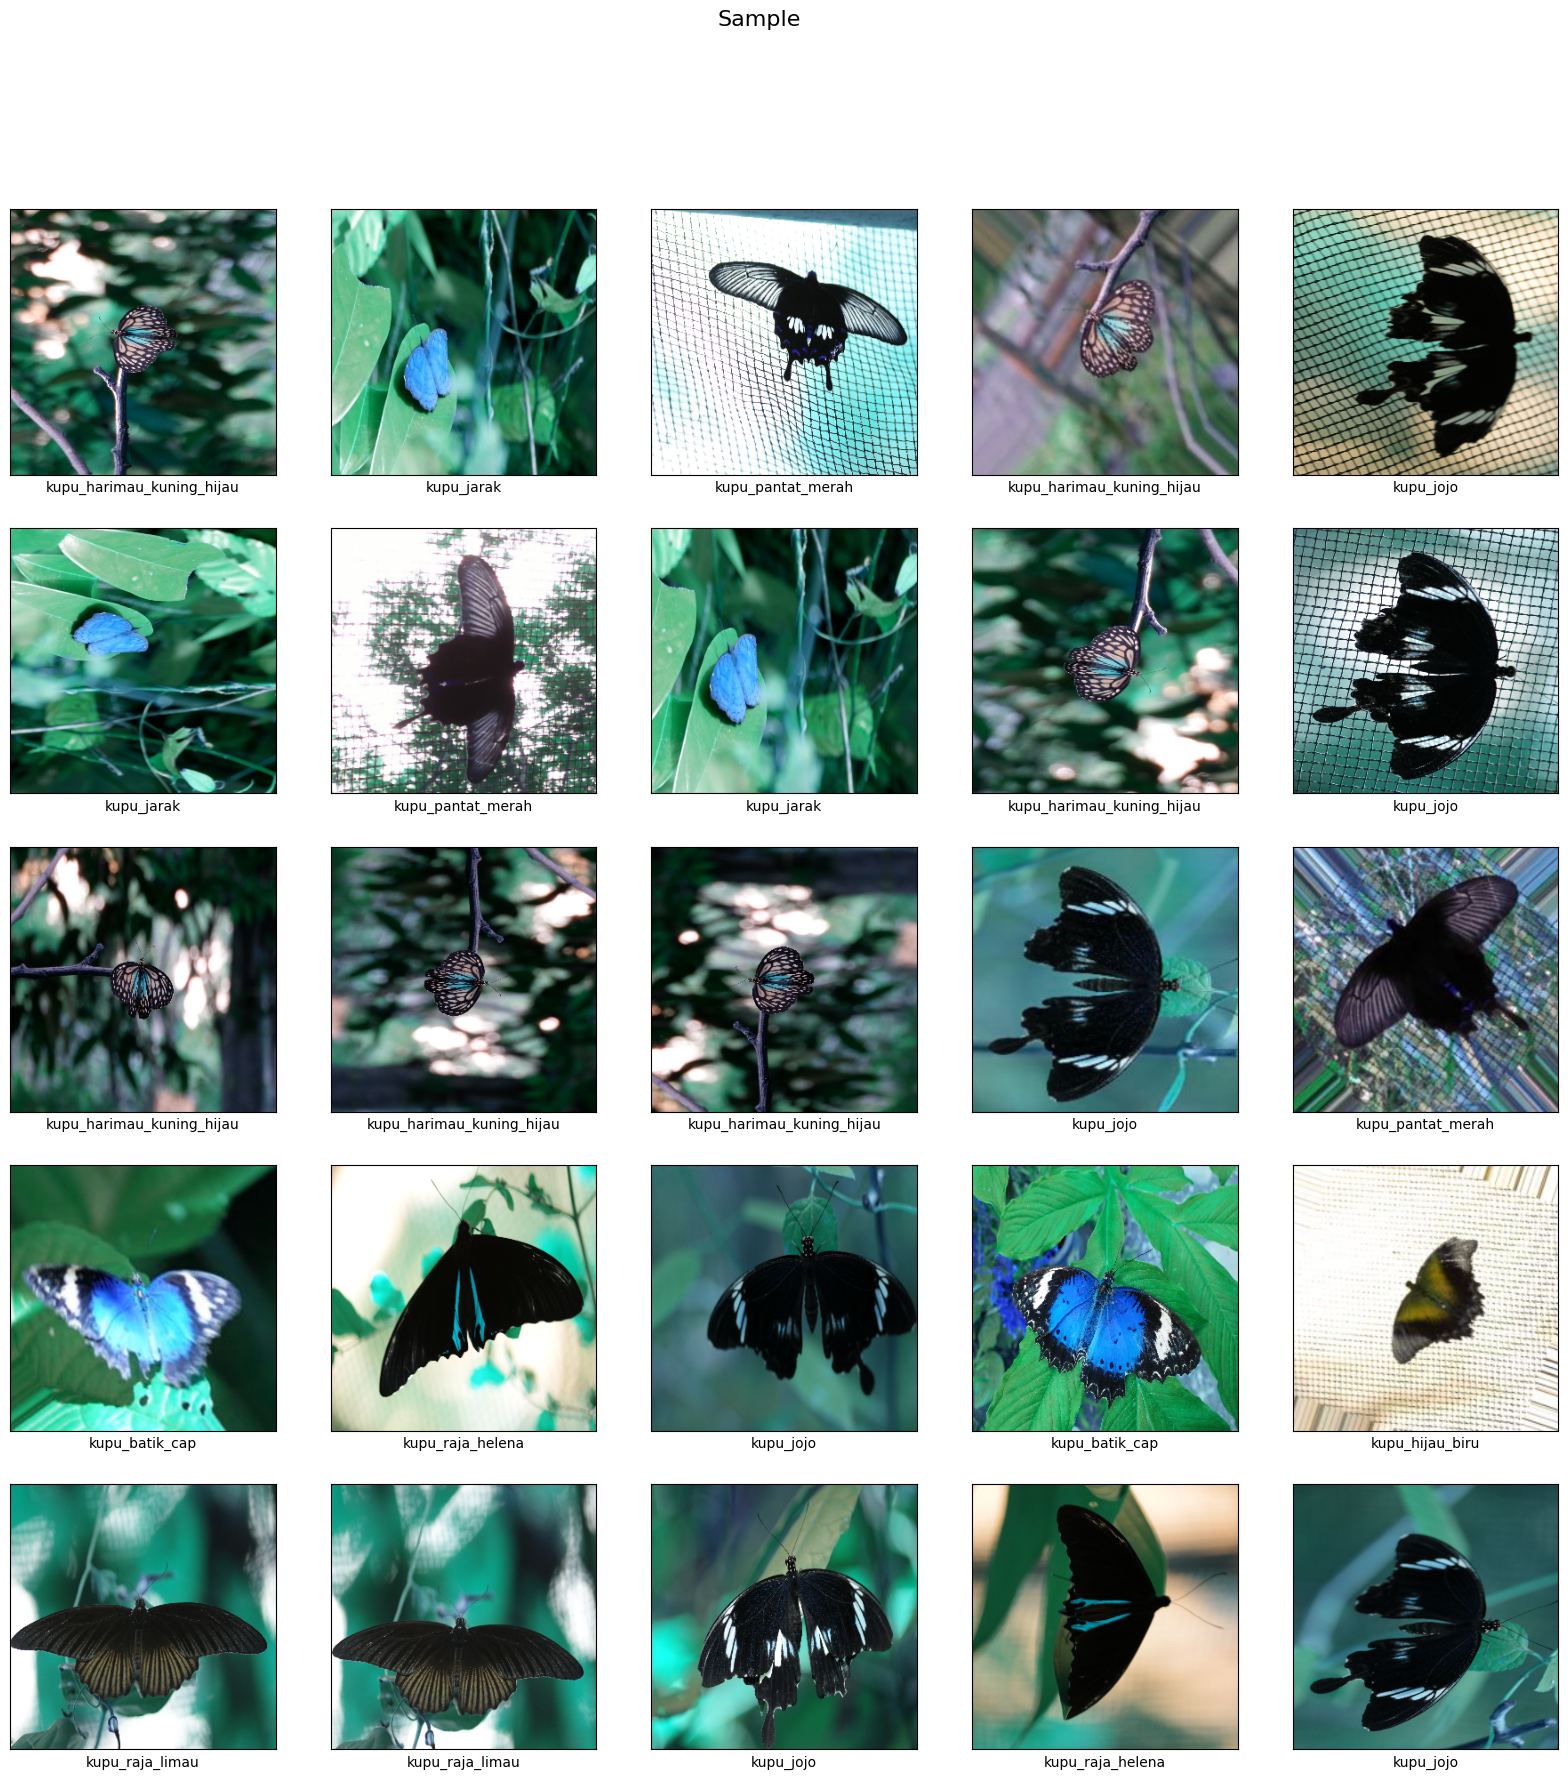

In [11]:
display_examples(class_names, train_images, train_labels)

In [14]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [42]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=8,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=8,
                                                         class_mode='sparse')

test_dataset = validation_data.flow_from_directory(test_dir,
                                                   target_size=IMG_SIZE,
                                                   batch_size=8,
                                                   class_mode='sparse')

AttributeError: 'DirectoryIterator' object has no attribute 'flow_from_directory'

In [17]:
train_images = tf.keras.applications.inception_resnet_v2.preprocess_input(train_images)
test_images = tf.keras.applications.inception_resnet_v2.preprocess_input(test_images)

In [18]:
input_shape = IMG_SIZE + (3,)

In [45]:
# Definisi model custom InceptionResNetV2
def build_model_inception_resnet_v2():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False  # Bekukan lapisan pretrained

    inputs = Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(train_data.num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [24]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

In [25]:
base_model.trainable = False

In [47]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [46]:
# Membuat model
model = build_model_inception_resnet_v2()

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
)

In [44]:
# Load data menggunakan ImageDataGenerator
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Sesuaikan dengan jenis klasifikasi Anda
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = validation_data.flow_from_directory(test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1120 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


In [48]:
# Latih model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6348 - loss: 1.1601 - val_accuracy: 0.9312 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 133s 902ms/step - accuracy: 0.9081 - loss: 0.3499 - val_accuracy: 0.9750 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 135s 859ms/step - accuracy: 0.9439 - loss: 0.1640 - val_accuracy: 0.9688 - val_loss: 0.0703 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 151s 933ms/step - accuracy: 0.9412 - loss: 0.1878 - val_accuracy: 0.9688 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 127s 867ms/step - accuracy: 0.9457 - loss: 0.1707 - val_accuracy: 0.9875 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 145s 885ms/step - accuracy: 0.9579 - loss: 0.1624 - val_accuracy: 0.9937 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 130s 882ms/step - accuracy: 0.9443 - l

In [49]:
# Ringkasan model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,083,002 (225.38 MB)

 Trainable params: 1,582,088 (6.04 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 3,164,178 (12.07 MB)

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step


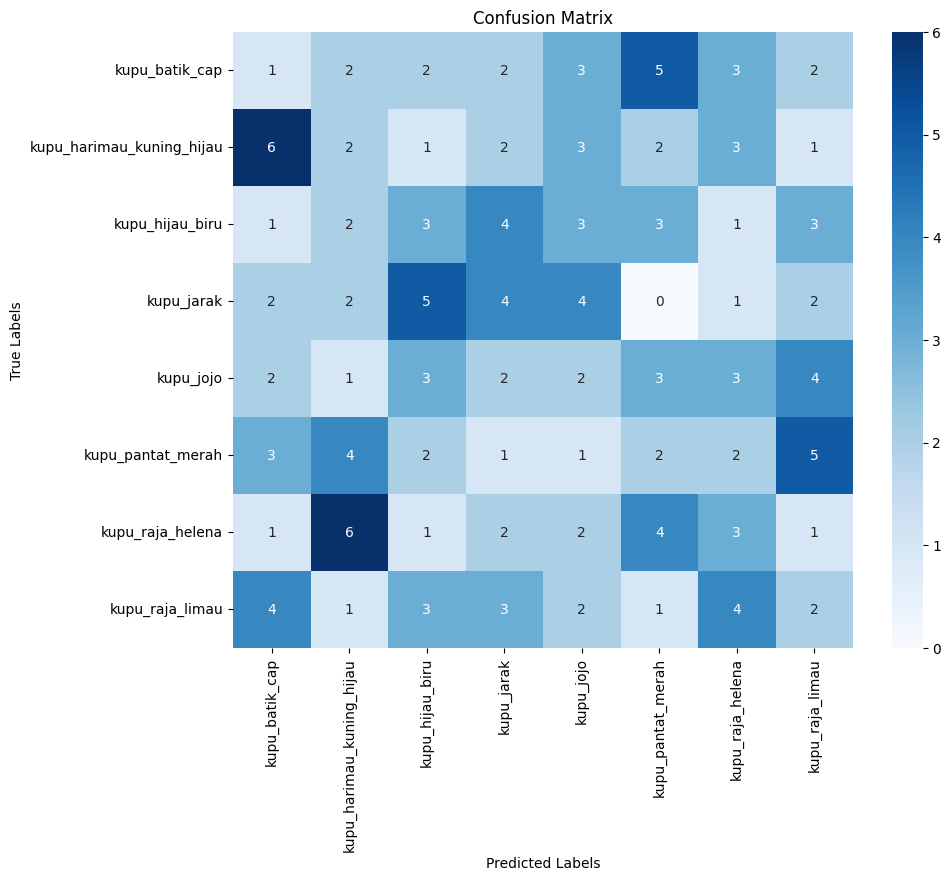

Classification Report:

                           precision    recall  f1-score   support

           kupu_batik_cap       0.05      0.05      0.05        20
kupu_harimau_kuning_hijau       0.10      0.10      0.10        20
          kupu_hijau_biru       0.15      0.15      0.15        20
               kupu_jarak       0.20      0.20      0.20        20
                kupu_jojo       0.10      0.10      0.10        20
        kupu_pantat_merah       0.10      0.10      0.10        20
         kupu_raja_helena       0.15      0.15      0.15        20
          kupu_raja_limau       0.10      0.10      0.10        20

                 accuracy                           0.12       160
                macro avg       0.12      0.12      0.12       160
             weighted avg       0.12      0.12      0.12       160



In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prediksi pada data uji
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = val_data.classes  # Label asli dari validation dataset

# Mendapatkan nama kelas
class_labels = list(val_data.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Menampilkan laporan klasifikasi
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))